#### Description of the data
0. ASI01_AUS01: Australia from 15th of December to 9th of January. Was compared to TSO data
1. ASI01_IDN01: Indonesia from 10th to 21st of November
2. ASI01_MYS01: Malaysia from 30th of October to 9th of November 
3. ASI01_MYS02: Malaysia from 4th to 14th of December
4. ASI01_SGP01: Singapore from 22nd November to 2nd of December

#### Combine MYS01 and MYS 02 together
##### Select QI=0

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import skew, kurtosis

folder_path = 'C:/1.1 Asia frequency data'
file_names = os.listdir(folder_path)

dataframes=[]
for file_name in file_names:
    file_path=os.path.join(folder_path, file_name)
    df=pd.read_csv(file_path, sep=';') 
    df.iloc[:,1]=df.iloc[:,1]/1000+50
    dataframes.append(df)

    
# dataframes[0] is Australia, [1] is Indonesia, [2] is Malaysia01, [3] is Malaysia02, [4] is Sinagpore
# combine dataframe[2] and dataframe[3]
combined_df = pd.concat([dataframes[2], dataframes[3]], ignore_index=True)

# replace dataframe[2] and dataframe[3] with combined_df in dataframes list
dataframes[2:4] = [combined_df]

# dataframes[0] is Australia
# dataframes[1] is Indonesia
# dataframes[2] is Malaysia
# dataframes[3] is Sinagpore


# Only select quality QI=0
flt_dataframes = []
for df in dataframes:
    flt_df = df[df['QI'] == 0]
    flt_dataframes.append(flt_df)
    
region_dict = {0: 'Australia', 1: 'Indonesia', 2: 'Malaysia',  3: 'Singapore'}

# Group the dataframes by region
region_groups = [df.groupby(lambda x: region_dict[i]) for i, df in enumerate(flt_dataframes)]    

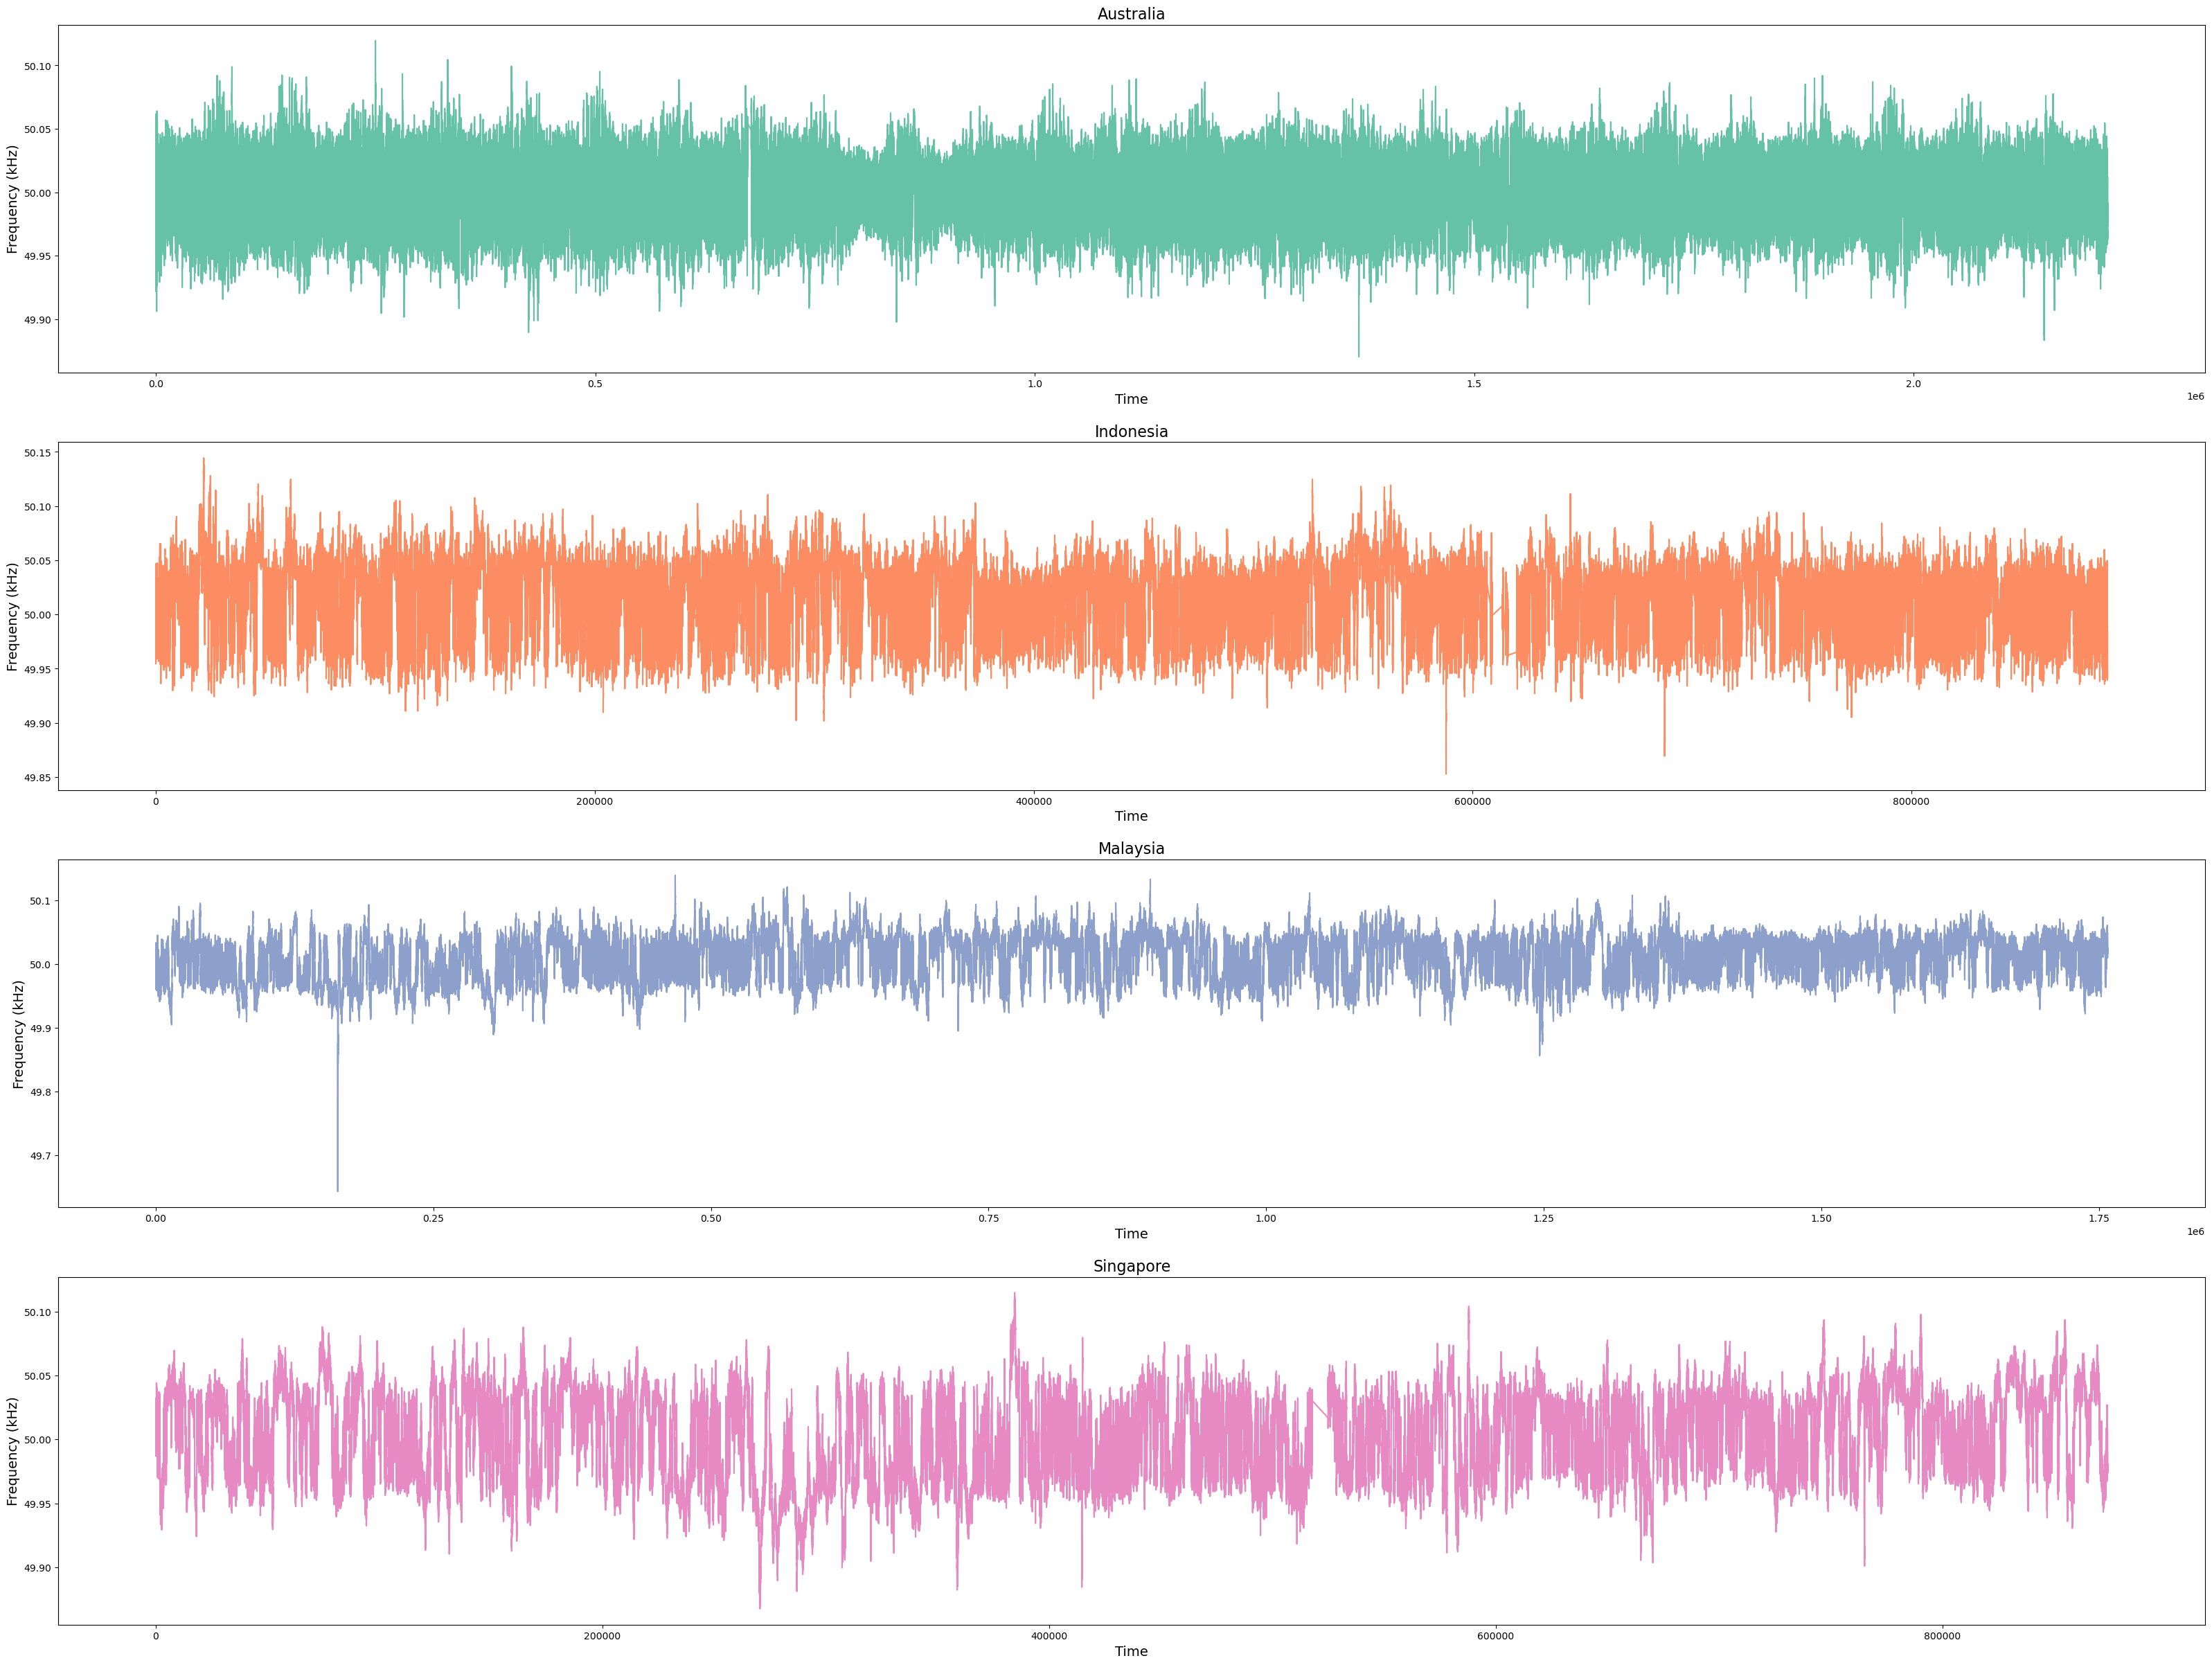

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

colors=('#66c2a5', '#fc8d62','#8da0cb','#e78ac3')

fig, axs = plt.subplots(nrows=len(flt_dataframes), figsize=(40,30))

for i, df in enumerate(flt_dataframes):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

In [3]:
from statsmodels.tsa.stattools import kpss

for i, df in enumerate(flt_dataframes):
    data = df.iloc[:, 1].dropna().values
    result = kpss(data, regression="c", nlags="auto")
    test_statistic = result[0]
    p_value = result[1]

    if p_value < 0.05:
        print(f"Region {region_dict[i]}: p-value = {p_value:.4f} (Non-Stationary)")
    else:
        print(f"Region {region_dict[i]}: p-value = {p_value:.4f} (Stationary)")


      

Region Australia: p-value = 0.1000 (Stationary)
Region Indonesia: p-value = 0.0100 (Non-Stationary)
Region Malaysia: p-value = 0.0100 (Non-Stationary)
Region Singapore: p-value = 0.0100 (Non-Stationary)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is small

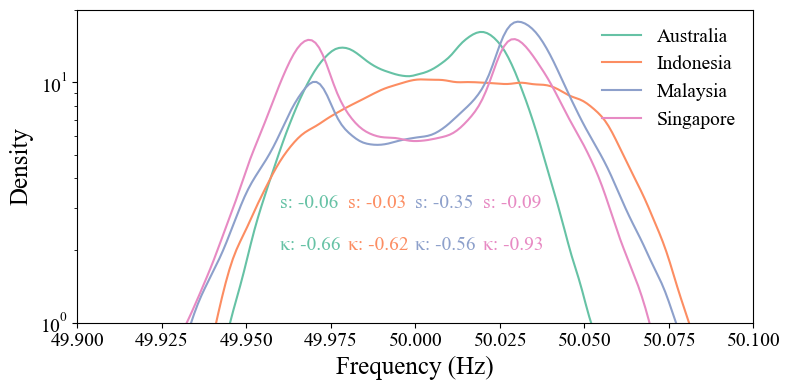

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

filtered_dfs = []
for i, df in enumerate(flt_dataframes):
    data = df[(df['f50'] >= 49.9) & (df['f50'] <= 50.1)]
    filtered_dfs.append(data)
    sns.kdeplot(data['f50'], color=colors[i], ax=ax, label=region_dict[i])
    
skewness = []
kurtosis = []

for df in filtered_dfs:
    skewness.append(df['f50'].skew())
    kurtosis.append(df['f50'].kurtosis() + 3)  

#ax.set_title('Asia-Australia', fontsize=12)
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.set_yscale('log') 
ax.set_xlim([49.9, 50.1])
ax.set_ylim([1, 20])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

s = np.array(skewness)
k = np.array(kurtosis)

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(49.96+i*0.02, 3, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(49.96+i*0.02, 2, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)


plt.legend(fontsize=14, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()


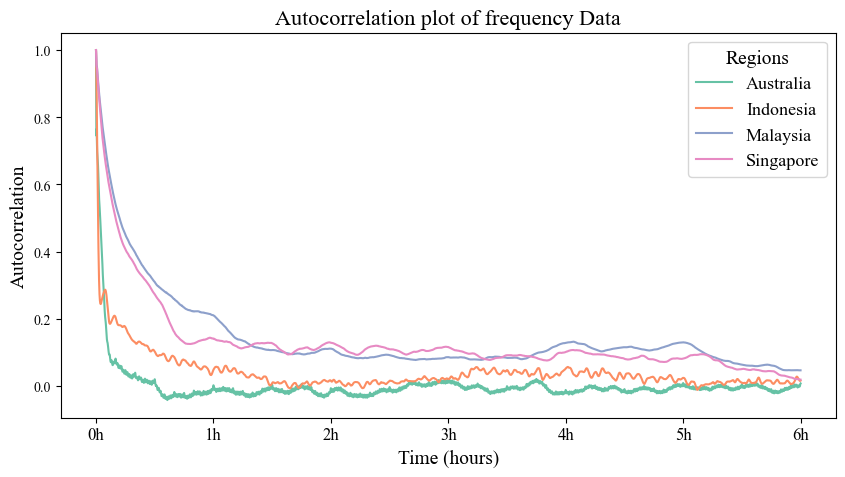

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit

fig, ax = plt.subplots(figsize=(10, 5))

# Define the time range in hours
time_range = np.arange(0, 7)

for i, df in enumerate(flt_dataframes):
    data = df.iloc[:, 1].dropna().values
    acf_vals = acf(data, nlags=3600*6)
    ax.plot(acf_vals, color=colors[i], label=region_dict[i])
    
    
ax.set_title('Autocorrelation plot of frequency Data', fontsize=16)
ax.set_xlabel('Time (hours)', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

ticks = np.arange(0, 3600*7, 3600)
tick_labels = [f'{i//3600}h' for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, fontsize=12)


plt.legend(title="Regions", title_fontsize=14, fontsize=13, loc='upper right')
plt.show()


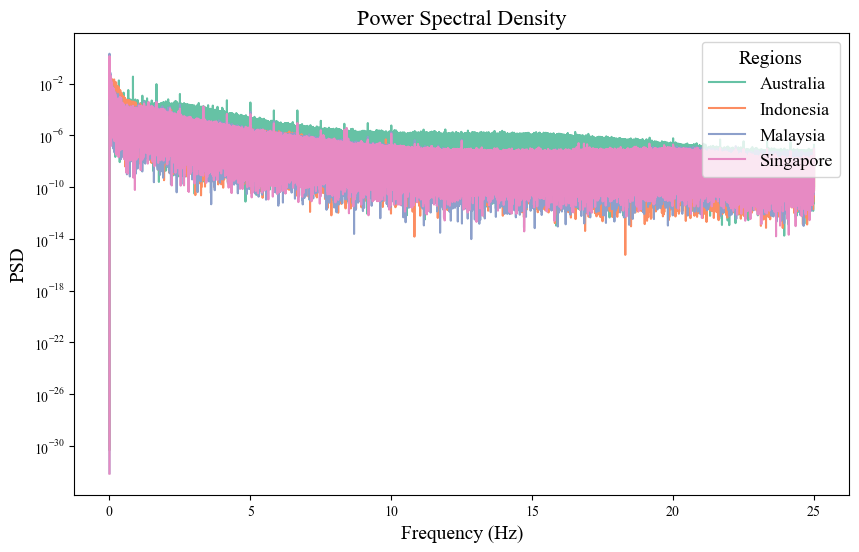

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# Set up some parameters for the periodogram
fs = 50  # Sampling frequency (Hz)
nperseg = 256  # Number of samples per segment

fig, ax = plt.subplots(figsize=(10,6))

for i, df in enumerate(flt_dataframes):
    data = df.iloc[:,1].dropna().values-np.mean(df.iloc[:,1].dropna().values)
    f, Pxx = periodogram(data, fs=fs,scaling='density')
    ax.semilogy(f, Pxx, color=colors[i], label=region_dict[i])

ax.set_title('Power Spectral Density',fontsize=16)
ax.set_xlabel('Frequency (Hz)',fontsize=14)
ax.set_ylabel('PSD',fontsize=14)

plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')

plt.show()

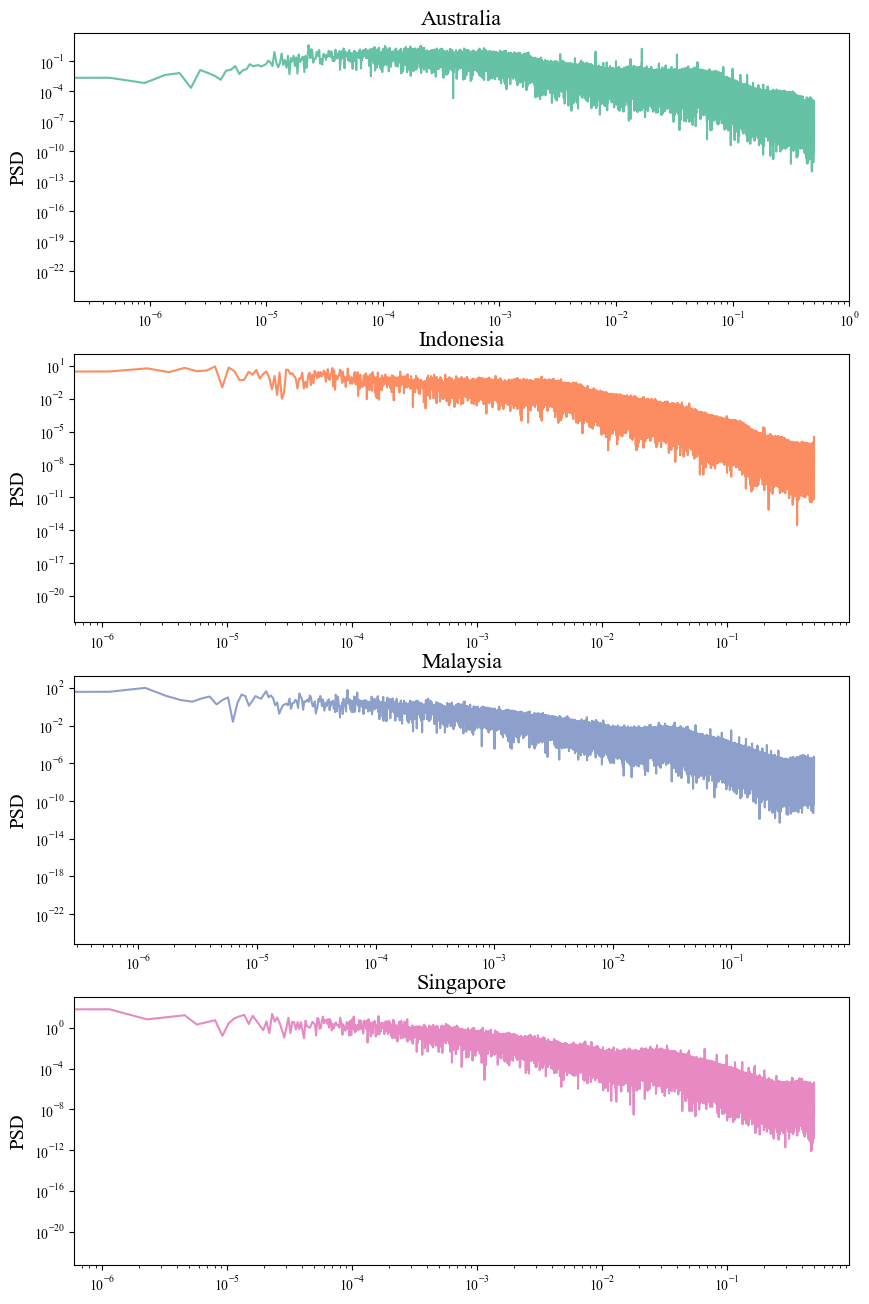

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# Set up some parameters for the periodogram
fs = 1  
nperseg = 256  

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 16))

for i, df in enumerate(flt_dataframes):
    data = df.iloc[:,1].dropna().values
    f, Pxx = periodogram(data, fs=fs)
    axs[i].plot(f, Pxx, color=colors[i])
    axs[i].set_title(region_dict[i],fontsize=16)
    axs[i].set_ylabel('PSD',fontsize=14)
    #axs[i].set_xlim([0,0.0002])
    axs[i].set_xscale('log') 
    axs[i].set_yscale('log') 


plt.show()